<a href="https://colab.research.google.com/github/huytranvan2010/GANs-Tutorial/blob/master/mnist_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST

In [ ]:
from tensorflow.keras.datasets import mnist

# load images
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# check shapes
print('Shape for train:', x_train.shape, y_train.shape)
print('Shape for test:', x_test.shape, y_test.shape)

Shape for train: (60000, 28, 28) (60000,)
Shape for test: (10000, 28, 28) (10000,)


### Luôn hiển thị dữ liệu ban đầu.

Ảnh ban đầu với black background (giá trị pixel = 0) và các chữ số màu trằng (giá trị pixels gần 255). Khi hiên thị sẽ thấy đa phần màu đen và các chữ số nằm giữa. Muốn hiển thị đúng thì dùng `cmap='gray'` còn muốn hiển hiển thị ngược lại cho dễ nhìn thì dùng `cmap='gray_r'`.

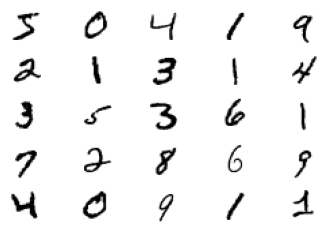

In [ ]:
import matplotlib.pyplot as plt

for i in range(25):
    # define subplot
    plt.subplot(5, 5, i+1)     # 5 hàng 5 cột, bắt đầu từ 1
    # turn off axis
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray_r')

plt.show()

Chúng ta sẽ sử dụng các ảnh trong training dataset để train GANs. Cụ thể generator model sẽ học cách tạo ra các chữ số mới, discriminator cố gắng phân biệt giữa ảnh thật từ training dataset và ảnh được tạo ra từ generator model.

## Define and train Discriminator model

Discriminator model sẽ lấy ảnh từ dataset làm input và đưa ra prediction ảnh đó là real hay fake. Đây là bài toán binary classification.

Discriminator có 2 Conv layers với 64 filters cho mỗi layer, kernel size = 3, stride = 2. Discriminator model không dùng Pooling layers, output layer có 1 unit với sigmoid activation function để dự đoán đầu ra. Model được train để minimize binary cross entropy loss function. 

**Một số best practice cho disciminator**:
- Sử dụng LeakyReLU: $\text{max}(\alpha x, x)$
- sử dụng Dropout
- sử dụng Adam version of SGD với learniing rate 0.0002 và momentum 0.5

Bên dưới chúng ta đi tạo hàm *define_discriminator()* để  định nghĩa discriminator model.

In [ ]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, LeakyReLU, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import numpy as np 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3136)            

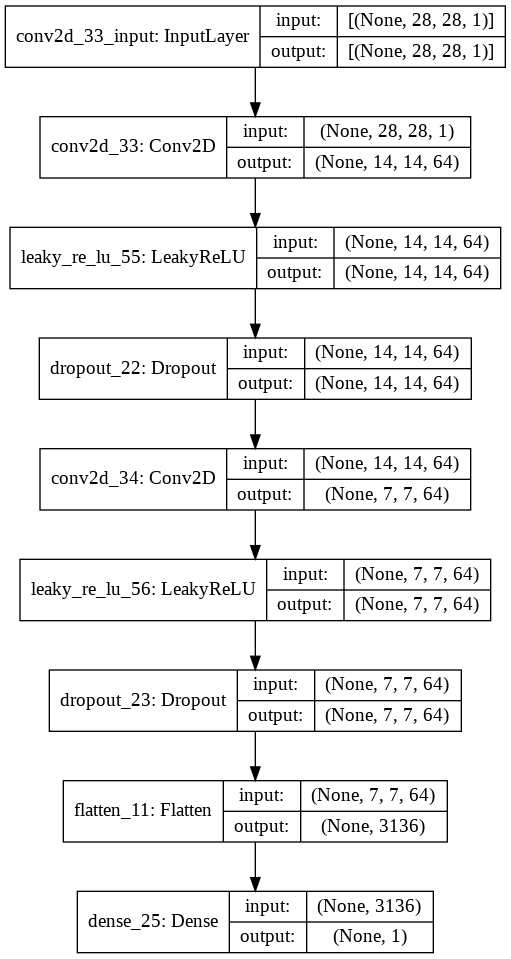

In [ ]:
# ảnh mnist có kích thước 28x28
def define_discriminator(input_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), strides=(2, 2),  padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    #compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

    return model

# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator.png', show_shapes=True)


Nhận thấy ở đây sử dụng Conv layer với strides=`2x2` đã giảm kích thước xuống một nửa (giống kiểu Pooling layer).

**VÌ SAO: ở trên dùng padding='same' sao kích thước đầu ra của Conv layer vẫn giảm**
- Bình thường nếu `stride=1` thì `padding='same'` sẽ giúp output có spatial dimensions giống với input
- Nếu `stride > 1` mà vẫn sử dụng `padding='same'` thì padding = p là giá trị **min** để mà $\frac{n+2p-f}{s}$ nguyên, nghĩa $n+2p-s$ chia hết cho $s$. Ví dụ ở trên, input có kích thước `28x28`, `stride=2`, `padding='same'`, kernel_size=3, lúc này $p=0.5$.

>Chú ý: $p$ có thể nhận giá trị thập phân (tính trung bình cho 2 phía). Không biết lúc thêm thì thêm bên mặt nào nhỉ.

https://stackoverflow.com/questions/48491728/what-is-the-behavior-of-same-padding-when-stride-is-greater-than-1

https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215


Bây giờ chúng ta có thể bắt đầu training discriminator model bằng real examples từ dataset với label = 1 và generated examples (từ generator) với label = 0. Discriminator thực chất là một NN model cho binary classification.

Chúng ta cần load và chuẩn bị dataset. Ở đây có sử dụng Conv2D nên chúng nó mog đợi input với 3 dimensions (chưa tính batch size) nên chúng ta cần mở rộng chiều của dataset. Ở đây cũng đưa giá trị pixel về [0, 1] để model nhanh hội tụ hơn.

In [ ]:
(x_train, _), (_, _) = mnist.load_data()

# mở rộng chiều
X = np.expand_dims(x_train, axis=-1)

# convert to float (vì nó đang lưu unsigned integer)
X = X.astype('float32')

# sclae froom [0, 255] to [0, 1]
X = X / 255.

Chúng ta gộp tất cả lại để xây dựng hàm `load_real_samples()`

In [ ]:
def load_real_samples():
    # load mnist dataset
    (x_train, _), (_, _) = mnist.load_data()
    # expand dimension
    X = np.expand_dims(x_train, axis=-1)
    # convert to float
    X = X.astype('float32')
    # scale to [0, 1]
    X = X / 255.

    return X

Model sẽ được update theo batches, cụ thể với collection của real samples và collection của generated samples. Khi training epoch được định nghĩa như 1 lần đi qua tất cả các training dataset.

Chúng ta có thể duyệt qua tất cả các samples trong training dataset, nhưng quá trình training tốt thông qua stochastic gradient descent cần training dataset được xáo trộn. **Cách đơn giản hơn là chọn ngẫu nhiên các samples từ training dataset**.

Bên dưới sẽ xây dựng hàm `generate_real_samples()` **cho các ảnh thật**, nó nhận vào training dataset như đối số và sẽ chọn các random subsample của images. Hàm này sẽ trả về class labels của các sample (ở đây là 1 tương ứng với real image).

> Chú ý: Chúng ta đi xây dựng dần dần rồi gộp lại vào các hàm lớn hơn.


In [ ]:
# chọn n_samples real samples
def generate_real_samples(dataset, n_samples):
    # chọn instances bất kì
    idx = np.random.randint(0, dataset.shape[0], n_samples)     # trả về list, ko lấy cận trên
    # lấy các ảnh được chọn
    X = dataset[idx]
    # tạo nhãn cho các ảnh đó, label = 1
    y = np.ones((n_samples, 1))     # tương ứng với số ảnh được lấy
    # trả về ảnh và label
    return X, y     

Bên trên chúng ta đã có hàm để tạo input cho ảnh thật. **Nên nhớ ảnh đầu vào đã được scaled về [0, 1]**. Bây giwof chúng ta cần tạo input cho ảnh giả.

Hiện tại chúng ta chưa có generator model, tuy nhiên chúng ta có thể tạo ảnh chứa các random pixel vales (nằm trong [0,1] như real images sau khi được scale).

Bên dưới đi định nghĩa hàm `generate_fake_samples()` để tạo ra ảnh giả (có các pixels năm trong khoảng [0, 1]).

In [ ]:
# chọn n_samples fake images with labels = 0
def generate_fake_samples(n_samples):
    # tạo các số trong [0, 1] với uniform distribution
    X = np.random.rand(28 * 28 * n_samples)
    # reshape lại cho thành batch of images with n_samples
    X = X.reshape((n_samples, 28, 28, 1))
    # tạo nhãn cho fake images, labels = 0
    y = np.zeros((n_samples, 1))
    # trả về X, y
    return X, y

Cuối cùng chúng ta cần train discriminator model. Điều này liên quan đến việc lặp lại lấy real images và generated images sau đó update mode qua các iterations.

Hiện tại chúng ta tạm bỏ qua khái niệm epoch và fit discriminator cho một số lượng batches. Discriminator sẽ học cách phân biệt giữa real images và fake images, sẽ không cần quá trình batches để discriminator có thể phân biệt một cách hoàn hảo (đang nói về fake images được tạo ra theo kiểu random này).

Hàm `train_discriminator()` bên dưới sẽ thực hiện điều này, sử dụng batch_size = 256 với 128 real images và 128 fake images cho mỗi iteration.

Ở đây chúng ta sẽ update discriminator riêng rẽ cho real images và fake images để chúng ta có thể tính được accuracy của model trên mỗi loại ảnh đó trước khi update. **Đúng rôi, nếu cho ta update chung thì không tính được cho từng loại, mà chỉ tính chung được cho tất cả các ảnh**. Việc này giúp chúng ta có cái nhìn sâu sắc (insight) về discriminator hơn.

In [ ]:
# train the discrinimator model
# dataset cho real images
def train_disscriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = n_batch // 2
    # manually enumerate epochs
    for i in range(n_iter):
        # lấy ramdonm real images
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real images, Runs a single gradient update on a single batch of data.
        _, real_acc = model.train_on_batch(X_real, y_real)      # khi muốn train trên collention of samples

        # tạo fake samples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        
        # summarize performance
        print(f'iteration {i+1}: real_acc = {real_acc *100}, fake_acc = {fake_acc *100}')


**Tập hợp lại tất cả những cái trên cho training standalone discriminator trên real images và generated images**

In [ ]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, LeakyReLU, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
import numpy as np 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

# DEFINE standalone (độc lập) discriminator
def define_discriminator(input_shape=(28, 28, 1)):  # # ảnh mnist có kích thước 28x28
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), strides=(2, 2),  padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    #compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    return model

# LOAD AND PREPARE MNIST dataset
def load_real_samples():
    # load mnist dataset
    (x_train, _), (_, _) = mnist.load_data()
    # expand dimension
    X = np.expand_dims(x_train, axis=-1)
    # convert to float
    X = X.astype('float32')
    # scale to [0, 1]
    X = X / 255.
    return X

# CHỌN n_samples real samples, labels = 1
def generate_real_samples(dataset, n_samples):
    # chọn instances bất kì
    idx = np.random.randint(0, dataset.shape[0], n_samples)     # trả về list, ko lấy cận trên
    # lấy các ảnh được chọn
    X = dataset[idx]
    # tạo nhãn cho các ảnh đó, label = 1
    y = np.ones((n_samples, 1))     # tương ứng với số ảnh được lấy
    # trả về ảnh và label
    return X, y     

# CHỌN n_samples fake images with labels = 0
def generate_fake_samples(n_samples):
    # tạo các số trong [0, 1] với uniform distribution
    X = np.random.rand(28 * 28 * n_samples)
    # reshape lại cho thành batch of images with n_samples
    X = X.reshape((n_samples, 28, 28, 1))
    # tạo nhãn cho fake images, labels = 0
    y = np.zeros((n_samples, 1))
    # trả về X, y
    return X, y

# train the discrinimator model
# dataset cho real images
def train_disscriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = n_batch // 2
    # manually enumerate epochs
    for i in range(n_iter):
        # lấy ramdonm real images
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real images, Runs a single gradient update on a single batch of data.
        _, real_acc = model.train_on_batch(X_real, y_real)      # khi muốn train trên collention of samples

        # tạo fake samples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        
        # summarize performance
        print(f'iteration {i+1}: real_acc = {real_acc *100}, fake_acc = {fake_acc *100}')

# define the discriminator model
model = define_discriminator()

# load real images
dataset = load_real_samples()

# fit the model
train_disscriminator(model, dataset)

iteration 1: real_acc = 71.09375, fake_acc = 9.375
iteration 2: real_acc = 61.71875, fake_acc = 20.3125
iteration 3: real_acc = 60.9375, fake_acc = 30.46875
iteration 4: real_acc = 71.09375, fake_acc = 58.59375
iteration 5: real_acc = 64.0625, fake_acc = 71.875
iteration 6: real_acc = 60.9375, fake_acc = 89.0625
iteration 7: real_acc = 64.0625, fake_acc = 92.1875
iteration 8: real_acc = 60.15625, fake_acc = 96.875
iteration 9: real_acc = 53.125, fake_acc = 99.21875
iteration 10: real_acc = 56.25, fake_acc = 99.21875
iteration 11: real_acc = 59.375, fake_acc = 100.0
iteration 12: real_acc = 57.8125, fake_acc = 99.21875
iteration 13: real_acc = 57.8125, fake_acc = 100.0
iteration 14: real_acc = 56.25, fake_acc = 100.0
iteration 15: real_acc = 57.03125, fake_acc = 100.0
iteration 16: real_acc = 63.28125, fake_acc = 100.0
iteration 17: real_acc = 54.6875, fake_acc = 100.0
iteration 18: real_acc = 67.1875, fake_acc = 100.0
iteration 19: real_acc = 65.625, fake_acc = 100.0
iteration 20: real

Nhận thấy tậm khoảng 40 batches discriminator có thể phân biệt hoàn hảo giữa real images và fake generated images.

Như vậy chúng ta đã tìm hiểu cách xây dựng và train standalone discriminator model. Bây giờ sẽ chuyển sang generator.

## How to define and use the generator model

Generator model có nhiệm vụ sinh ra ảnh chữ số mới hợp lý.

Nó sẽ từ latent space (không gian ẩn) làm input và đưa ra grayscle image làm output. 

**Latent space** là vector có độ bài bất kỳ (các giá trị được chọn thường từ phân bố Gaussian), thường dimension hay chọn là 100. Chúng ta hoàn toàn có thể sử dụng các giá trị khác để thử nghiệm. 
- **Input** - point trong latent space, 100 element vectpr of Gaussian random numbers
- **Output** - 2 dimensional grayscale image of `28x28` pixels với pixels values trong [0, 1]

Generator sẽ giúp chungsta chuyển vector từ vector từ latent space 100 dimensions sang không gian 2D `28x28`.

Có một số cách giúp chúng ta đạt được điều này nhưng có một các tiếp cận đã được chứng minh hiệu quả trong deep convilutional generative adversarial networks, Nó bao gôm 2 thành phần chính:
- Đầu tiên là Dense layer (hidden layer đầu tiên) chứa số lượng nodes (hay units) đủ để biểu diễn *low resolution version* của output image. Như bình thường ảnh đầu ra có kích thước `28x28`, thì một nửa alf `14x14`, một phần tư là `7x7` tương ứng với 49 units.
- Chúng ta không muốn một low resolution version của image, chúng ta muốn có nhiều version hay nhiều nội suy của input. Điều này khá tương đồng với ConvNet khi chúng ta có nhiều filters để học được nhiều features khác nhau. Chúng ta cũng muốn điều tương tự nhưng theo chiều ngược lại (cần lớp Dense với nhiều units). Nhiều features học được sẽ gộp lại (collapse) với nhau để tạo output. 


In [ ]:
# 1-st hidden layer
model.add(Dense(128 * 7 * 7, input_dim = 100))

Sau đó chúng ta reshpae lại để giống kiểu images, có 3 dimensions (ko tính batch_size)

In [ ]:
model.add(Reshape((7, 7, 128)))     # 128 7x7x feature maps

Công việc tiếp theo caanf upsampling lơ-resolution image to a higher-resolution version of the image.

Có một số cách để thực hiện upsampling, có thể xem [tại đây](https://huytranvan2010.github.io/Transposed-Convolution/).

Một cách chúng ta dùng *UpSampling2D* (giống kiểu unpooling layer) theo sau bởi COnv2D layer. Cách khác hiện tại hay dùng hơn là sử dụng Conv2DTranspose

In [ ]:
# upsample to 14x14
model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))

Trong phần này chúng ta vẫn sử dụng LeakyReLU với slope = 0.2. Output layer chúng ta sẽ sử dụng Conv2D với 1 filter, kernel_size = `7x7` và `padding = same` để tạo ra single feature map và bảo toàn dimension `28x28`. Ở đây sigmoid được sử dụng để đảm bảo các giá trị đầu ra nằm trong [0, 1]. **Nhớ bên trên không, đầu vào của discriminator đã được scale về [0, 1] nên mình dùng sigmoid ở output layer của generator là hợp lý**.

Bên dưới chúng ta đi định nghĩa hàm `define_generator()`.

> Chú ý: generator model chúng ta không compile, không chỉ định loss function và optimization algorithm. Có điều này do chúng ta không train trực tiếp generator mà sẽ gộp nó với discriminator và train thông qua đó.

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim = latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))     # được feature map 7x7

    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model
    

Chúng ta có thể summarize model để hiểu hơn về input và output shapes như sau.

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 28, 28, 128)     

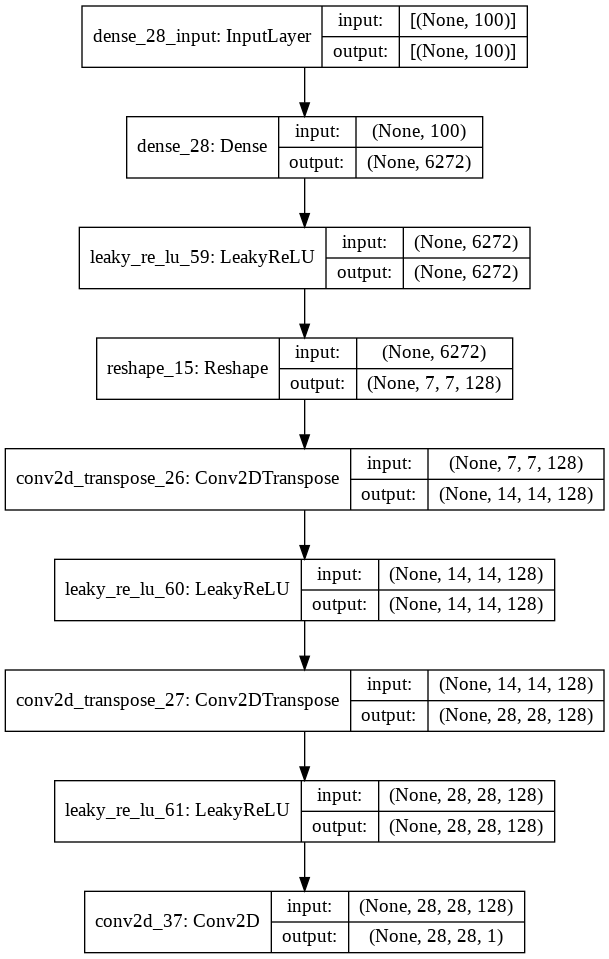

In [ ]:
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))     # chỗ này input_dim nhé, Conv2D là input_shape
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))     # được feature map 7x7

    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

# define the size of the latent sapce
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)



>**CÂU HỎI**: Sao Conv2D cuối cùng dùng kernel_size lớn như vậy `7x7`?


Generator model đến thời điểm hiện tại không thể làm gì thêm (bên trên chúng ta không xác định optimizer algorithm, loss function cho nó). Tuy nhiên chúng ta có thể dùng generator model để sinh các samples.

**Bước đầu tiên** chúng ta thực hiện là tạo ra các new points trong latent space. Chúng ta làm điều này với `np.random.randn()`, nó trả về các giá trị trong [0, 1) với phân bố Gaussian. Hàm `generate_latent_points()` sẽ tạo ra số lượng points mong muốn để sử dụng làm input của generator.

In [ ]:
# Tạo latent points làm input cho generator model
def generate_latent_points(latent_dim, n_samples):
    # tạo các điểm
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape thành batch of inputs
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

Chúng ta có thể sử dụng các generated points được tạo ra làm input của generator model, đầu ra chúng ta nhận được fake samples. Trong phần này chúng ta sẽ chỉnh lại hàm `generate_fake_samples()` bên trên với đầu vào là *generator model*, trong đó chúng ta sẽ gọi hàm `generate_latent_points()`.

In [ ]:
# Sử dụng generator model để tạo fake samples,labels = 0
def generate_fake_samples(g_model, latent_dim, n_samples):
    # tạo points trong latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # cho x_input đi qua generator model để tạo output bằng predict
    X = g_model.predict(x_input)
    # tạo labels cho fake examples, labels = 0
    y = np.zeros((n_samples, 1))

    return X, y

Một đoạn code đầy đủ để tạo MNIST images với untrained generator model và chúng ta sẽ vẽ đầu ra xem thế nào

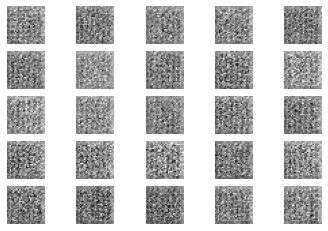

In [ ]:
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))     # chỗ này input_dim nhé, Conv2D là input_shape
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))     # được feature map 7x7

    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

# Tạo latent points làm input cho generator model
def generate_latent_points(latent_dim, n_samples):
    # tạo các điểm
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape thành batch of inputs
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Sử dụng generator model để tạo fake samples,labels = 0
def generate_fake_samples(g_model, latent_dim, n_samples):
    # tạo points trong latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # cho x_input đi qua generator model để tạo output bằng predict
    X = g_model.predict(x_input)
    # tạo labels cho fake examples, labels = 0
    y = np.zeros((n_samples, 1))
    return X, y

# define the size of the latent sapce
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)

# generate fake samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)

# plot generated samples
for i in range(n_samples):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0], cmap='gray_r')    # có thể thay đổi cmap
    # Nên nhớ X trả về là tensor 4 chiều (n_sampeles, 28, 28, 1) do đó cần biến đổi để hiển thị được

plt.show()


Sau khi chạy ví dụ này chúng ta đã tạo được 25 FAKE examples of MNIST images và biểu diễn chúng. Bởi vì generator chưa được train nên các pixels values cũng chưa tạo được chữ số nào.

## How to train the Generator Model

**Weights của generator model được update dựa trên performance của discriminator model.**
- Discriminator mà phân biệt ảnh thật giả dễ dàng thì generator càng được cập nhật nhiều để cho ảnh fake khó phân biệt hơn
- Discriminator mà phân biệt thận giả kém, hay nhầm lần thật giả thì generator model sẽ được cập nhật ít thôi. Lúc này cũng đánh lừa được discriminator kha khá rồi đấy.

Điều trên xác định zero-sum or adversarial relationship (mối quan hệ đối nghịch) giữa 2 model. Rõ hơn thì thằng generator muốn tạo ảnh fake giống ảnh thật nhất, tương đương có $D(G(x)) \rightarrow 1$, tuy nhiên thằng discriminator nó lại muốn $D(G(x)) \rightarrow 0$ vì nó muốn phân biệt generated image là giả. OK chắc đã hiểu rõ hơn rồi.

Có thể có nhiều cách thực hiện điều này bằng cách sử dụng Keras API, có một cách đơn giản là tạo một model mới kết hợp của cả generator và discriminator.

Cụ thể hơn GAN model mới có thể được định nghĩa bằng cách chồng (stack) generator và discriminator sao cho generator nhận vào các random points in latent space và tạo ra các samples, các samples này được đưa vào discriminator để phân loại, output của larger model (GAN model) có thể được sử dụng để update model weights của generator. 

Discriminator chỉ quan tâm đến phân biệt real and fake examples, do đó discriminator model có thể được train đọc lập dựa dựa trên các examples như chúng ta làm ben trên.

Generator model lại chỉ quan tâm đến performance của discriminator trên các fake examples, **do đó chúng ta sẽ đánh dấu tất cả các layers của discriminator as not trainable (ko train) khi nó là một phần của GAN model (generator chỉ nhờ discriminator đánh giá hộ generated samples thôi)**. Điều này để discriminator không bị update và overtrain trên fake examples (nếu các layers của nó ở ra thì ở đây chỉ có trained trên fake examples từ generator là không tốt).

Khi train generator thông qua GAN model, có một thay đổi quan trọng nữa. Chúng ta muốn discriminator nghĩa rằng samples từ generator là real, không phải fake (**Bởi vì chúng ta đang muốn generator tạo ảnh fake mà gần giống với ảnh thật nhất. Nếu chúng ta vẫn gán nhãn là 0 thì discriminator gần chẳng phải làm gì nó xác định được đó là ảnh fake - đầu ra của generator là cái gì đó rất khác ảnh thật. Đó không phải mục tiêu của chúng ta**). Do đó khi chúng ta train generator như một phần của GAN model chúng ta sẽ đánh dấu generated samples là real (class 1). 

Cụ thể hơn đi. Tưởng tượng lúc đầu discriminator sẽ phân loại generated samples là fake (class 0) hay xác suất đầu ra thấp (ví dụ 0.2). Backpropagation sẽ tính được error cao (đánh generated samples có class 1), nó sẽ update model weights (của generator model) để correct các error này, đồng nghĩa với việc generator sẽ dần tạo ra các fake samples tốt hơn.

Đầu vào của GAN model là point in latent space (100 element vector of Gaussian random numbers). Output phân loại thật giả (binary classification).

Bên dưới đi định nghĩa hàm `def_gan()` để tạo ra GAN model từ generator model và discriminator model. Weights của discriminator được đánh dấu là *not trainabled*, điều này chỉ có nghĩa nghĩa trong GAN model, và không có ý nghĩa đối với standalone discriminatỏ model (khi discriminator đúng độc lập, train riêng rẽ thì vẫn cập nhật weights).

Trong GAN model vẫn sử dụng binary cross entropy loss function như discriminator và Adam version of SGD với learning rate 0.0002 và momentum 0.5.

In [ ]:
# define the combined generator và discriminator model để update the generator
def define_gan(g_model, d_model):
    # lamf weigts của discriminator not trainable
    d_model.trainable = False   # thực hiện trước khi compile GAN model
    # connect 2 model lại
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model



Xem thêm link để hiểu `trainable=False` https://keras.io/guides/transfer_learning/ làm như vậy tất cả các layers trong model sẽ được freeze. Nên nhớ trong Keras có 2 cách để freeze weights-
- `model.traiabel = False`, phải làm trước khi compile model
- `for layer in model.layers: layer.trainable = False`, hoạt đọng cả trước và sau compile

Xem thêm [tại đây](https://stackoverflow.com/questions/58224816/what-does-model-trainable-false-mean-in-keras).

Tính chất trainable ảnh hưởng đén model sau khi nó được compile. Discriminator đọc lập sẽ được compile với trainable layers, do đó các weights của nó được update khi gọi thông qua `train_on_batch()` - update weights thông qua một collection of data nào đó.

Trong GAN model, weights của discriminator không được update, không thay đổi khi GAN model được update thông qua `train_on_batch()`. Tất nhiên điều này không ảnh hưởng đến việc train standalone discriminator model.

Các câu hỏi thường gặp với Keras:
https://keras.io/getting_started/faq/#how-can-i-freeze-keras-layers

Bên dưới chúng ta sẽ tập hợp code là để tạo discriminator, generator và composite model.


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_32 (Sequential)   (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_31 (Sequential)   (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


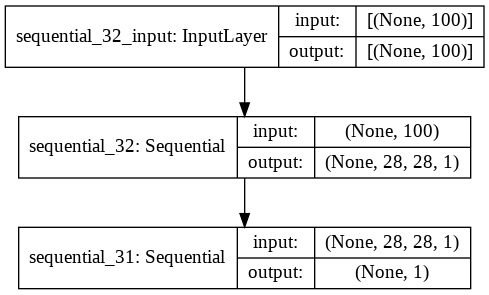

In [ ]:
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, Flatten, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# define the standalone discriminator model
def define_discriminator(input_shape=(28, 28, 1)):  # # ảnh mnist có kích thước 28x28
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), strides=(2, 2),  padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    #compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))     # chỗ này input_dim nhé, Conv2D là input_shape
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))     # được feature map 7x7

    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

# define the combined generator và discriminator model để update the generator
def define_gan(g_model, d_model):
    # lamf weigts của discriminator not trainable
    d_model.trainable = False   # thực hiện trước khi compile GAN model
    # connect 2 model lại
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# size of the laten space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()    # NHỚ discriminator có compile model nhé
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)


Chúng ta có thể thấy point in latent space qua generator được output shape (28, 28, 1), cái này đia vào discriminator để được output có giá trị.

Việc training the composite model (GAN model) liên quan đến việc tạo các batch of points in the latent space thông quan `generate_latent_points()`, `class=1` labels, chúng ta sẽ gọi `train_on_batch()` (cập nhật trên mỗi collection of data thôi, do mình còn train xen kẽ với discriminator).

Hàm `train_gan()` dưới đây làm sáng tỏ đièu đó, nó khá đơn giản chỉ update generator và giữ nguyên discriminator weights.

In [ ]:
# train the composite model - GAN model
def train_an(gan_model, latent_dim, n_epochs=100, n_batch=256):
    # manually enumerate epochs
    for _ in range(n_epochs):
        # chuẩn bị points in latent space như input của generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # tạo inverted labels for the fake samples (label = 1 để cố gắng làm giả tốt nhất)
        y_gan = np.ones((n_batch, 1))
        # update the generator thông qua discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)      # update weights của generator


Tất nhiên chúng ta cũng cần cập nhật discriminator thông qua các mẫu thật giả, sau đó sẽ update generator thông qua composite model.

Điều này dẫn đến chúng ta cần kết hợp `train_discriminator()` và `train_gan()`. Chúng ta sẽ train xen hai cái này xen kẽ nhau trong các epochs.

Có một số điểm cần chú ý khi kết hợp 2 cái này lại:
- Số batches trong mỗi epoch là $\frac{no ~ training ~ examples}{batch_size}$, làm tròn nhé. Ở đây $batch_size=256$, số training examples là 60000 như vậy có 234 batches cho mỗi epoch
- Discriminator model được update cho mỗi batch bằng cách kết hợp nửa batch của fake samples và nửa batch của real samples, chúng ta dùng [numpy.vstack()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html) để làm điều này. Chúng ta có thể tách riêng train trên nửa batch cho mỗi loại cũng được nhưng nên gộp vào để training nhanh hơn. Ở đây cho discriminator `batch_size = 256` có nghĩa là có 128 fake samples from generator và 128 real samples from MNIST dataset.
- Cuối cùng chúng ta sẽ cho hiển thị loss sau mỗi batch. Điều này quan trọng vì chúng ta có thể kiểm soát được loss. Nguyên nhân cho việc này là vì nếu loss của discriminator quá nhỏ là dấu hiệu cho việc generator bắt đầu tạo ra các ảnh mà discriminator dễ dàng phân biệt (ta không muốn điều này).
- Mong đợi discriminator loss trong khoảng 0.5 đến 0.8 mỗi batch trên MNIST dataset. Generator loss ít quan trọng hơn (is les critial) và có thể trong khoản 0.5 đến 2 cho bộ dữ liệu này. 

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_space, n_epochs=100, n_batch=256):
    batch_per_epoch = dataset.shape[0] // n_batch
    half_batch = n_batch // 2

    # manually enumerate epochs
    for i in range(n_epochs):
        # duyệt qua các batches
        for j in range(batch_per_epoch):
            # UPDATE CHO discriminator
            # lấy ngẫu nhiên real samples từ MNIST dataset
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # tạo fake examples để train discriminator
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)     # lấy từ generator nhé
            # tạo training set cho discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)    # discriminator được compile để update nhé

            # UPDATE CHO generator
            # chuẩn bị points in the latent space như input của generator
            X_gan = generate_latent_points(latent_dim, n_batch)     # lấy 256 luôn
            # tạo inverted labels for fake samples , label sẽ  =1
            y_gan = np.ones((n_batch, 1))
            # update the generator thông qua performance của discriminator
            g_loss = gan_model.train_on_batch(X_gan, y_gan)     # nếu không muốn return loss thì chỉ cần model.train_ob_batch(...)

            # summarize loss on this batch
            print(">{}: {}/{} d_loss={:.2f} g_loss={0:.2f}".format(i+1, j+1, batch_per_epoch, d_loss, g_loss))


Bên trên chúng ta để giá trị trả về đối với `train_on_batch()`, có thể xem thêm [tại đây](https://keras.io/api/models/model_training_apis/).
- Đối với discriminator model, chúng ta có metrics là `acc` nên nó sẽ trả về list of scalars (loss đầu tiên)
- GAN model chúng ta không để metrics do đó chỉ có một giá trị loss trả về. 
Cần chú ý điều này khi debug.

## How to ecaluate GAN model performance

Nhìn chung không có cách khách quan nào (objective way) để đánh giá performance của GAN model.

Chúng ta không thể tính error score cho generated images. Điều này có thể cho MNIST dataset vì khá rõ ràng tuy nhiên nhìn chung là không thể.

Thay vào đó images có thể được đánh giá thông qua con người. Điều này có nghãi rằng chúng ta không thể biết được khi nào nên dùng training mà không nhìn vào generated images. Do bản chất đối nghịc của GAN mà các hình ảnh thay đổi tốt hơn hoặc thậm chí xấu đi sau mỗi lần update.

Có 3 cách thường để xử lý vấn đề này:
- Định kỳ đánh giá classification accuracy của discriminator trên real images và fake images
- Định kỳ tạo ra images và lưu chúng để để đánh giá chủ quan
- Định lỳ lưu generator model

Tất cả các hoạt động trên có thể thực hiện cùng thời điểm cho một số lượng epochs, ví dụ sau 10 epochs thì lưu mọi thứ lại. 

Việc đào tạo GAN qua nhiều epochs và chúng ta lưu lại sau một số epochs cho phép chúng ta có thể kiểm tra lại sau này.

Chúng ta đi định nghĩa hàm `summarize_performance()` sẽ tổng hợp lại performance của discriminator

In [ ]:
# evaluate the discroinator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # chuẩn bị real samples
    # Mấy samples này lấy lại không liên quan mấy cái train bên trên
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # đánh giá discriminator trên real samples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # chuẩn bị fake samples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # đánh giá discriminator trên fake samples
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(f'Accuracy real: {acc_real * 100}, fake: {acc_fake * 100}')

Cũng tương tự như `train_on_batch()` cần chú ý giá trị trả về của `evaluate()`. Xem thêm [tại đây](https://keras.io/api/models/model_training_apis/#evaluate-method). Ở đây đối với discriminator có loss và metric nó sẽ trả về loss và acc.

https://stackoverflow.com/questions/51299836/what-values-are-returned-from-model-evaluate-in-keras/51303340

Hàm này có thể được gọi từ hàm `train()` dựa trên số epoch hiện tại ví dụ sau mỗi 10 epochs.


In [ ]:
# # train the generator and discriminator
# def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
# 	batch_per_epoch = dataset.shape[0] // n_batch
# 	half_batch = n_batch // 2
# 	# manually enumerate epochs
# 	for i in range(n_epochs):
# 	...
# 	# evaluate the model performance, sometimes
# 	if (i+1) % 10 == 0:
# 		summarize_performance(i, g_model, d_model, dataset, latent_dim)

Tiếp theo chúng ta có thể update `summarize_performance()` bằng cách lưu model, tạo và lưu các generated examples.

Generator model có thể được lưu bằng cách gọi `save()`, ví dụ như sau
```python
filename = 'generator_model_{:04d}.h5'.format(epoch + 1)
g_model.save(filename)
```

Chúng ta tạo thêm hàm để vẽ các generated samples. Nếu chúng ta đã đánh giá discriminator bằng 100 generated MNIST images chúng ta có thể vẽ tất cả 100 images lên 10x10 grid. Hàm `save_plot()` sẽ thực hiện điều này và lưu plot lại với tên duy nhất dựa trên epoch number.

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_{:04d}.png'.format(epoch + 1)
    plt.savefig(filename)
    plt.close()

TỔng kết lại chúng ta có hàm `summarize_performance()`.

In [ ]:
# evaluate the discroinator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # chuẩn bị real samples
    # Mấy samples này lấy lại không liên quan mấy cái train bên trên
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # đánh giá discriminator trên real samples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # chuẩn bị fake samples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # đánh giá discriminator trên fake samples
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(f'Accuracy real: {acc_real * 100}, fake: {acc_fake * 100}')

    # save plot
    save_plot(X_fake, epoch)    # X_fake chính là ảnh được tạo ra ngay bên trên
    # save the generator model title file
    filename = 'generated_model_{:04d}.h5'.format(epoch + 1)
    g_model.save(filename)

## Tổng kết tất cả lại

In [ ]:
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, Flatten, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# define the standalone discriminator model
def define_discriminator(input_shape=(28, 28, 1)):  # # ảnh mnist có kích thước 28x28
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), strides=(2, 2),  padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    #compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))     # chỗ này input_dim nhé, Conv2D là input_shape
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))     # được feature map 7x7

    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

# define the combined generator và discriminator model để update the generator
def define_gan(g_model, d_model):
    # lamf weigts của discriminator not trainable
    d_model.trainable = False   # thực hiện trước khi compile GAN model
    # connect 2 model lại
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# LOAD AND PREPARE MNIST dataset
def load_real_samples():
    # load mnist dataset
    (x_train, _), (_, _) = mnist.load_data()
    # expand dimension
    X = np.expand_dims(x_train, axis=-1)
    # convert to float
    X = X.astype('float32')
    # scale to [0, 1]
    X = X / 255.
    return X

# CHỌN n_samples real samples, labels = 1
def generate_real_samples(dataset, n_samples):
    # chọn instances bất kì
    idx = np.random.randint(0, dataset.shape[0], n_samples)     # trả về list, ko lấy cận trên
    # lấy các ảnh được chọn
    X = dataset[idx]
    # tạo nhãn cho các ảnh đó, label = 1
    y = np.ones((n_samples, 1))     # tương ứng với số ảnh được lấy
    # trả về ảnh và label
    return X, y     

# Tạo latent points làm input cho generator model
def generate_latent_points(latent_dim, n_samples):
    # tạo các điểm
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape thành batch of inputs
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Sử dụng generator model để tạo fake samples,labels = 0
def generate_fake_samples(g_model, latent_dim, n_samples):
    # tạo points trong latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # cho x_input đi qua generator model để tạo output bằng predict
    X = g_model.predict(x_input)
    # tạo labels cho fake examples, labels = 0
    y = np.zeros((n_samples, 1))
    return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_{:04d}.png'.format(epoch + 1)
    plt.savefig(filename)
    plt.close()

# evaluate the discroinator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # chuẩn bị real samples
    # Mấy samples này lấy lại không liên quan mấy cái train bên trên
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # đánh giá discriminator trên real samples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # chuẩn bị fake samples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # đánh giá discriminator trên fake samples
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(f'Accuracy real: {acc_real * 100}, fake: {acc_fake * 100}')

    # save plot
    save_plot(X_fake, epoch)    # X_fake chính là ảnh được tạo ra ngay bên trên
    # save the generator model title file
    filename = 'generated_model_{:04d}.h5'.format(epoch + 1)
    g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_space, n_epochs=100, n_batch=256):
    batch_per_epoch = dataset.shape[0] // n_batch
    half_batch = n_batch // 2

    # manually enumerate epochs
    for i in range(n_epochs):
        # duyệt qua các batches
        for j in range(batch_per_epoch):
            # UPDATE CHO discriminator
            # lấy ngẫu nhiên real samples từ MNIST dataset
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # tạo fake examples để train discriminator
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)     # lấy từ generator nhé
            # tạo training set cho discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)    # discriminator được compile để update nhé

            # UPDATE CHO generator
            # chuẩn bị points in the latent space như input của generator
            X_gan = generate_latent_points(latent_dim, n_batch)     # lấy 256 luôn
            # tạo inverted labels for fake samples , label sẽ  =1
            y_gan = np.ones((n_batch, 1))
            # update the generator thông qua performance của discriminator
            g_loss = gan_model.train_on_batch(X_gan, y_gan)     # nếu không muốn return loss thì chỉ cần model.train_ob_batch(...)

            # summarize loss on this batch
            print(">{}: {}/{} d_loss={:.2f} g_loss={:.2f}".format(i+1, j+1, batch_per_epoch, d_loss, g_loss))
        
        # evaluate the model performance
        if (i+1)%10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            

# size of the laten space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()    # NHỚ discriminator có compile model nhé
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>79: 155/234 d_loss=0.69 g_loss=0.70
>79: 156/234 d_loss=0.70 g_loss=0.70
>79: 157/234 d_loss=0.69 g_loss=0.70
>79: 158/234 d_loss=0.69 g_loss=0.70
>79: 159/234 d_loss=0.69 g_loss=0.71
>79: 160/234 d_loss=0.69 g_loss=0.71
>79: 161/234 d_loss=0.69 g_loss=0.71
>79: 162/234 d_loss=0.69 g_loss=0.70
>79: 163/234 d_loss=0.68 g_loss=0.69
>79: 164/234 d_loss=0.69 g_loss=0.70
>79: 165/234 d_loss=0.69 g_loss=0.70
>79: 166/234 d_loss=0.70 g_loss=0.70
>79: 167/234 d_loss=0.68 g_loss=0.70
>79: 168/234 d_loss=0.69 g_loss=0.70
>79: 169/234 d_loss=0.69 g_loss=0.72
>79: 170/234 d_loss=0.70 g_loss=0.72
>79: 171/234 d_loss=0.69 g_loss=0.70
>79: 172/234 d_loss=0.69 g_loss=0.70
>79: 173/234 d_loss=0.70 g_loss=0.71
>79: 174/234 d_loss=0.70 g_loss=0.73
>79: 175/234 d_loss=0.69 g_loss=0.71
>79: 176/234 d_loss=0.68 g_loss=0.71
>79: 177/234 d_loss=0.69 g_loss=0.69
>79: 178/234 d_loss=0.69 g_loss=0.69
>79: 179/234 d_loss=0.71 g_loss=0.72
>79: 180/234 d_loss=0.68

Bên trên có thể thêm k, để huấn luyện được k steps cho generator thì mới huấn luyện discriminator 1 lần.

Xem thêm phần format string ở đây 

https://stackoverflow.com/questions/46768088/valueerror-cannot-switch-from-manual-field-specification-to-automatic-field-num

https://thepythonguru.com/python-string-formatting/


## How to use the final Generator model to generate images

Khi có final generator model chúng ta có thể sử dụng nó riêng biệt để  phục vụ cho ứng dụng của chúng ta. Chúng ta có thể load model và dùng nó để tạo ra images. **Quá trình tạo image cũng cần point trong latent space như input.**

Bên dưới là code để sinh ảnh từ trained generator model.

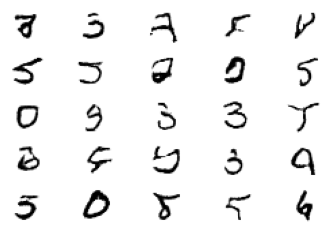

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Tạo latent points làm input cho generator model
def generate_latent_points(latent_dim, n_samples):
    # tạo các điểm
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape thành batch of inputs
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

# load model
model = load_model('generated_model_0100.h5')
# tạo points trong latent space
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

Ở đây chúng ta sủ dụng trained generator model đã được train sau 100 epochs. 

Bên dưới chúng ta có thể một point bất kỳ trong latent space để xem ảnh tạo ra như nào.

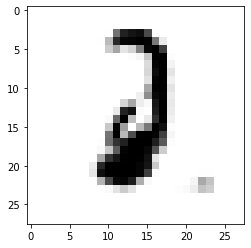

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# load model
model = load_model('generated_model_0100.h5')
# tạo vector toàn 1
vector = np.ones((1, 100))
# generate image
X = model.predict(vector)
# plot the result
plt.imshow(X[0, :, :, 0], cmap='gray_r')    # batch_size = 1, nên lấy chỉ số 0
plt.show()

## Mở rộng

Dưới đây là một số tips có thể sử dụng:
- Scale image về [-1, 1] làm đầu vào của discriminator, do đó output của generator cũng nằm trong đó nên sẽ dùng `tanh` activation cho output layer của generator.
- Thay đổi latent space xem ảnh hưởng như thế nào đến chất lượng ảnh
- Sử dụng **Batch Normalization** cho discriminator và/hoặc generator (DCGAN models)
- Label smoothing: Khi training discriminator có thể gán nhãn cho real samples từ 1 về 0.9. Hãy thử một số phương án xem sao.
- Model configuration: có thay đổi architecture xem thế nào, model sâu hơn, nông hơn.

## Xem thêm
1. https://github.com/Zackory/Keras-MNIST-GAN
2. https://github.com/eriklindernoren/Keras-GAN
3. https://github.com/kroosen/GAN-in-keras-on-mnist
4. https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/?unapproved=625686&moderation-hash=d0431a6602608e2289a18a3ea9b9caff#comment-625686
5. https://phamdinhkhanh.github.io/2020/07/13/GAN.html#21-m%C3%B4-h%C3%ACnh-hi%E1%BB%87n-explicit-model


